In [14]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

##### Load Daniel Shan Balico's dataset.
- Carry out a train-validation split using sci-kit learn.
- Reshape images to (3, 224, 224), flatten and load into 'trainimages', 'valimages' and 'testimages' array.
- Subsequently store labels into 'trainlabels', 'valimages' and 'testlabels' array.

In [15]:
dataframe = pd.read_csv('data/Daniel_Shan_Balico/labels.csv')
dataframe.info()
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4000 non-null   int64 
 1   filename    4000 non-null   object
 2   label       4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.9+ KB


,Unnamed: 0,filename,label
0,0,yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg,sad
1,1,c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg,sad
2,2,RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg,angry
3,3,gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg,angry
4,4,U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg,relaxed


##### Create Stratified Shuffle Split on labels dataframe.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_val_index, test_index in sss.split(dataframe, dataframe['label']):
    train_val_set = dataframe.loc[train_val_index]
    test_set = dataframe.loc[test_index]

In [17]:
for train_index, val_index in sss.split(train_val_set, train_val_set['label']):
    train_set = dataframe.loc[train_index]
    val_set = dataframe.loc[val_index]

##### Get graphings.

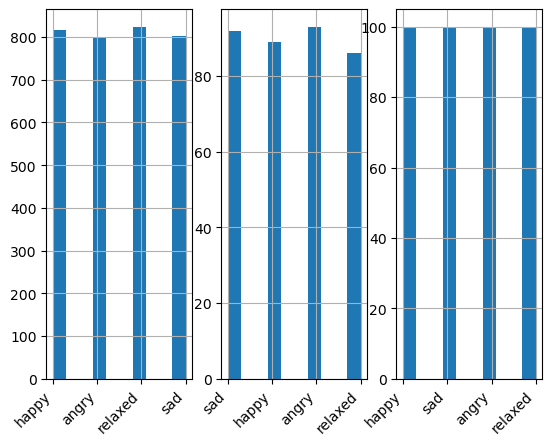

In [18]:
plt.subplot(1, 3, 1)
train_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
val_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
test_set['label'].hist()
plt.xticks(rotation=45, ha='right')

plt.show()

In [19]:
print('Train Examples:', train_set.shape[0])
print('Validation Examples:', val_set.shape[0])
print('Test Examples:', test_set.shape[0])

Train Examples: 3240
Validation Examples: 360
Test Examples: 400


##### Feed the images into the arrays.

In [20]:
trimages = np.array([], dtype=np.uint8).reshape((0, 3, 16, 16))
valimages = np.array([], dtype=np.uint8).reshape((0, 3, 16, 16))
testimages = np.array([], dtype=np.uint8).reshape((0, 3, 16, 16))
trlabels = np.array([])
vallabels = np.array([])
testlabels = np.array([])

label_dict = {'angry' : 0,
              'happy' : 1,
              'relaxed' : 2,
              'sad' : 3}

In [22]:
for index in tqdm(train_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + train_set['filename'][index])
    img = img.resize((16, 16))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 16, 16)
    trimages = np.append(trimages, img, axis = 0)
    trlabels = np.append(trlabels, label_dict[train_set['label'][index]])

for index in tqdm(val_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + val_set['filename'][index])
    img = img.resize((16, 16))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 16, 16)
    valimages = np.append(valimages, img, axis = 0)
    vallabels = np.append(vallabels, label_dict[val_set['label'][index]])

for index in tqdm(test_set.index):
    img = Image.open('data/Daniel_Shan_Balico/all_images/' + test_set['filename'][index])
    img = img.resize((16, 16))
    img = np.asarray(img)
    img = np.transpose(img, (2,0,1))
    img = img.reshape(1, 3, 16, 16)
    testimages = np.append(testimages, img, axis = 0)
    testlabels = np.append(testlabels, label_dict[test_set['label'][index]])

100%|██████████| 400/400 [00:00<00:00, 439.24it/s]


In [23]:
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/trimages', trimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/valimages', valimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/testimages', testimages)
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/trlabels', trlabels)
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/vallabels', vallabels)
np.save('data/Daniel_Shan_Balico/numpy_arrays_16/testlabels', testlabels)

In [24]:
trimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/trimages.npy')
valimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/valimages.npy')
testimages = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/testimages.npy')
trlabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/trlabels.npy')
vallabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/vallabels.npy')
testlabels = np.load('data/Daniel_Shan_Balico/numpy_arrays_16/testlabels.npy')

In [25]:
MEAN = np.mean(trimages/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(trimages/255.0,axis=(0,2,3),keepdims=True)
print(MEAN)
print(STD)

[[[[0.47403535]]

  [[0.44057435]]

  [[0.38688257]]]]
[[[[0.24377318]]

  [[0.23580266]]

  [[0.23789613]]]]


##### Data generator.
- All augmentations performed as listed in the SimCLR paper https://arxiv.org/abs/2002.05709.

In [26]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop((16, 16),(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.8*self.s, 
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):
        
        x = self.imgarr[idx] 
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))
        
        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)
        
        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame
    
    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):
        
        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame
        
        return frame

In [27]:
dg = C10DataGen('train',trimages)
dl = DataLoader(dg,batch_size = 128,drop_last=True)

vdg = C10DataGen('valid',valimages)
vdl = DataLoader(vdg,batch_size = 128,drop_last=True)

##### Set up model.
- The Identity module gives output what it takes as input.
- The LinearLayer module gives a single Linear layer followed by an optional BatchNormalization layer.
- The ProjectionHead module gives a linear or non-linear projection head according to the argument passed.
- The PreModel module gives the model to be used for pre-training, i.e. the base encoder f(.) with an MLP g(.) on top of it. 
- The class PreModel uses ResNet50. However, this can be modified according to your need and can even be made customizable with some little extra work.

In [28]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn
        
        self.linear = nn.Linear(self.in_features, 
                                self.out_features, 
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))
        
    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model):
        super().__init__()
        self.base_model = base_model
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        
        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        
        self.pretrained.fc = Identity()
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
        
        self.projector = ProjectionHead(2048, 2048, 128)

    def forward(self,x):
        out = self.pretrained(x)
        
        xp = self.projector(torch.squeeze(out))
        
        return xp

In [29]:
torch.cuda.empty_cache()
model = PreModel('resnet50').to('cuda:0')

/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Loss Function.
- The Loss function code has been taken from this repo (Spijkervet/SimCLR) and modified slightly. 

In [30]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

##### Optimizer.
- LARS Optimizer as instructed in the SimCLR paper https://arxiv.org/abs/2002.05709.
- Picked up from repo (Spijkervet/SimCLR).

In [31]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [32]:
#OPTMIZER
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

#LOSS FUNCTION
criterion = SimCLR_Loss(batch_size = 128, temperature = 0.5)

Adjusting learning rate of group 0 to 2.0000e-02.
Epoch 00000: adjusting learning rate of group 0 to 2.0000e-01.


##### Utility functions.

In [33]:
def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

def plot_features(model, num_classes, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)
    
    for i in range(num_classes):
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

In [34]:
import gc
torch.cuda.empty_cache()
gc.collect()

20399

##### Training Loop.

Epoch [0/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_6328/1065139194.py:129: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/

Step [0/25]	 Loss: 5.38015
Adjusting learning rate of group 0 to 4.0000e-02.
Step [0/2]	 Loss: 3.64236
Epoch [0/600]	 Training Loss: 5.3139151763916015	 lr: 0.04
Epoch [0/600]	 Validation Loss: 3.6421109437942505	 lr: 0.04
Epoch [0/600]	 Time Taken: 0.19934162298838298 minutes
Epoch [1/600]	
Step [0/25]	 Loss: 5.13694
Adjusting learning rate of group 0 to 6.0000e-02.
Step [0/2]	 Loss: 3.6718
Epoch [1/600]	 Training Loss: 5.108691291809082	 lr: 0.06
Epoch [1/600]	 Validation Loss: 3.6693092584609985	 lr: 0.06
Epoch [1/600]	 Time Taken: 0.180092716217041 minutes
Epoch [2/600]	
Step [0/25]	 Loss: 5.04291
Adjusting learning rate of group 0 to 8.0000e-02.
Step [0/2]	 Loss: 3.70876
Epoch [2/600]	 Training Loss: 5.018558959960938	 lr: 0.08
Epoch [2/600]	 Validation Loss: 3.711133122444153	 lr: 0.08
Epoch [2/600]	 Time Taken: 0.13996084928512573 minutes
Epoch [3/600]	
Step [0/25]	 Loss: 4.98563
Adjusting learning rate of group 0 to 1.0000e-01.
Step [0/2]	 Loss: 3.80173
Epoch [3/600]	 Training 

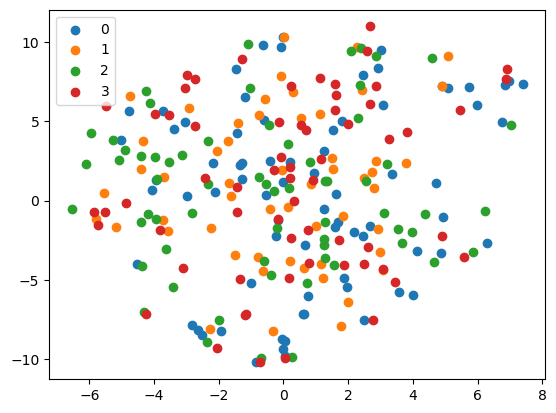

Epoch [10/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 4.15889
Epoch 00001: adjusting learning rate of group 0 to 2.0000e-01.
Step [0/2]	 Loss: 3.7974
Epoch [10/600]	 Training Loss: 4.118997592926025	 lr: 0.2
Epoch [10/600]	 Validation Loss: 3.7946704626083374	 lr: 0.2
Epoch [10/600]	 Time Taken: 0.1589460770289103 minutes
Epoch [11/600]	
Step [0/25]	 Loss: 4.03885
Epoch 00002: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/2]	 Loss: 3.78216
Epoch [11/600]	 Training Loss: 4.058551216125489	 lr: 0.19999
Epoch [11/600]	 Validation Loss: 3.779936909675598	 lr: 0.19999
Epoch [11/600]	 Time Taken: 0.14438603321711221 minutes
Epoch [12/600]	
Step [0/25]	 Loss: 4.07992
Epoch 00003: adjusting learning rate of group 0 to 1.9999e-01.
Step [0/2]	 Loss: 3.75949
Epoch [12/600]	 Training Loss: 4.022567691802979	 lr: 0.19999
Epoch [12/600]	 Validation Loss: 3.7576574087142944	 lr: 0.19999
Epoch [12/600]	 Time Taken: 0.17950925827026368 minutes
Epoch [13/600]	
Step [0/25]	 Loss: 4.01659
Epoch 00004: adjusting learning rate of

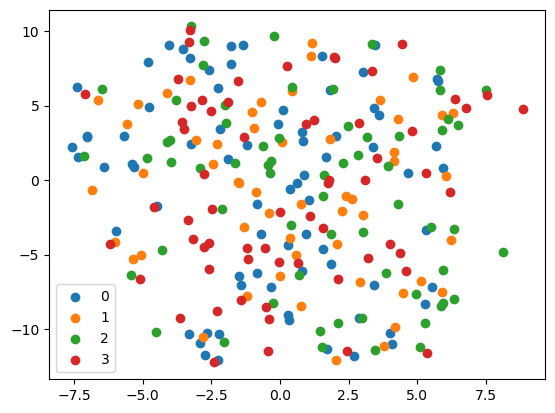

Epoch [20/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.8838
Epoch 00011: adjusting learning rate of group 0 to 1.9982e-01.
Step [0/2]	 Loss: 3.70863
Epoch [20/600]	 Training Loss: 3.8719597625732423	 lr: 0.19982
Epoch [20/600]	 Validation Loss: 3.7034857273101807	 lr: 0.19982
Epoch [20/600]	 Time Taken: 0.1253965934117635 minutes
Epoch [21/600]	
Step [0/25]	 Loss: 3.8727
Epoch 00012: adjusting learning rate of group 0 to 1.9979e-01.
Step [0/2]	 Loss: 3.69675
Epoch [21/600]	 Training Loss: 3.8609347915649415	 lr: 0.19979
Epoch [21/600]	 Validation Loss: 3.693707823753357	 lr: 0.19979
Epoch [21/600]	 Time Taken: 0.17059948841730754 minutes
Epoch [22/600]	
Step [0/25]	 Loss: 3.85818
Epoch 00013: adjusting learning rate of group 0 to 1.9975e-01.
Step [0/2]	 Loss: 3.69577
Epoch [22/600]	 Training Loss: 3.8463056564331053	 lr: 0.19975
Epoch [22/600]	 Validation Loss: 3.6909093856811523	 lr: 0.19975
Epoch [22/600]	 Time Taken: 0.1637557586034139 minutes
Epoch [23/600]	
Step [0/25]	 Loss: 3.8544
Epoch 00014: adjusting learning

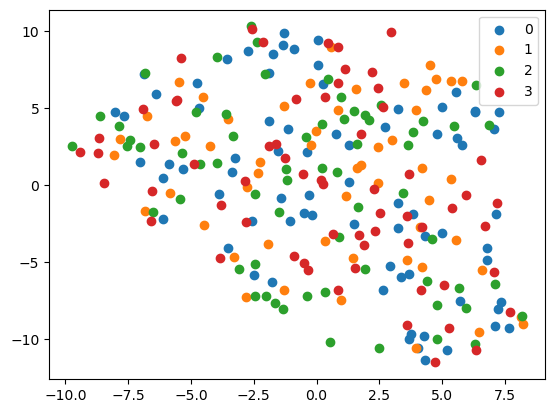

Epoch [30/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.79945
Epoch 00021: adjusting learning rate of group 0 to 1.9935e-01.
Step [0/2]	 Loss: 3.66669
Epoch [30/600]	 Training Loss: 3.7984585857391355	 lr: 0.19935
Epoch [30/600]	 Validation Loss: 3.664147734642029	 lr: 0.19935
Epoch [30/600]	 Time Taken: 0.1531154751777649 minutes
Epoch [31/600]	
Step [0/25]	 Loss: 3.80102
Epoch 00022: adjusting learning rate of group 0 to 1.9928e-01.
Step [0/2]	 Loss: 3.66922
Epoch [31/600]	 Training Loss: 3.79269700050354	 lr: 0.19928
Epoch [31/600]	 Validation Loss: 3.665596604347229	 lr: 0.19928
Epoch [31/600]	 Time Taken: 0.15417636235555013 minutes
Epoch [32/600]	
Step [0/25]	 Loss: 3.80572
Epoch 00023: adjusting learning rate of group 0 to 1.9922e-01.
Step [0/2]	 Loss: 3.66848
Epoch [32/600]	 Training Loss: 3.789339065551758	 lr: 0.19922
Epoch [32/600]	 Validation Loss: 3.6642825603485107	 lr: 0.19922
Epoch [32/600]	 Time Taken: 0.15755760272343952 minutes
Epoch [33/600]	
Step [0/25]	 Loss: 3.80875
Epoch 00024: adjusting learning

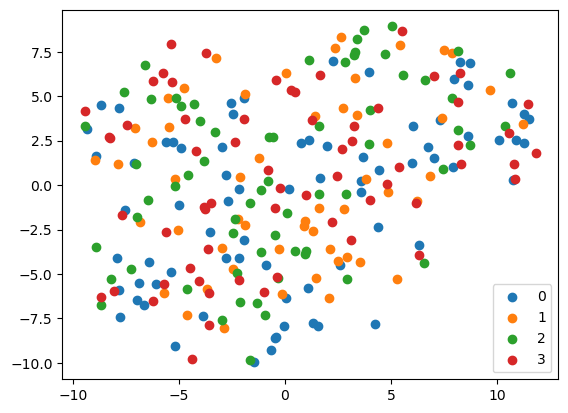

Epoch [40/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.80066
Epoch 00031: adjusting learning rate of group 0 to 1.9858e-01.
Step [0/2]	 Loss: 3.65802
Epoch [40/600]	 Training Loss: 3.7586489868164064	 lr: 0.19858
Epoch [40/600]	 Validation Loss: 3.653924345970154	 lr: 0.19858
Epoch [40/600]	 Time Taken: 0.1636652708053589 minutes
Epoch [41/600]	
Step [0/25]	 Loss: 3.7669
Epoch 00032: adjusting learning rate of group 0 to 1.9849e-01.
Step [0/2]	 Loss: 3.66035
Epoch [41/600]	 Training Loss: 3.7544957065582274	 lr: 0.19849
Epoch [41/600]	 Validation Loss: 3.6562740802764893	 lr: 0.19849
Epoch [41/600]	 Time Taken: 0.15432965755462646 minutes
Epoch [42/600]	
Step [0/25]	 Loss: 3.73692
Epoch 00033: adjusting learning rate of group 0 to 1.9839e-01.
Step [0/2]	 Loss: 3.65827
Epoch [42/600]	 Training Loss: 3.7552396965026857	 lr: 0.19839
Epoch [42/600]	 Validation Loss: 3.6521729230880737	 lr: 0.19839
Epoch [42/600]	 Time Taken: 0.1699187397956848 minutes
Epoch [43/600]	
Step [0/25]	 Loss: 3.76033
Epoch 00034: adjusting learni

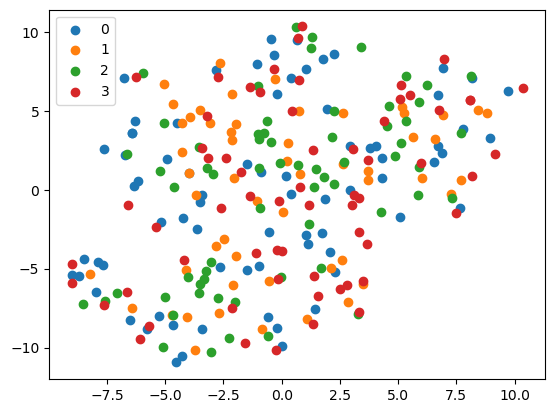

Epoch [50/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.7421
Epoch 00041: adjusting learning rate of group 0 to 1.9753e-01.
Step [0/2]	 Loss: 3.65491
Epoch [50/600]	 Training Loss: 3.7314395618438723	 lr: 0.19753
Epoch [50/600]	 Validation Loss: 3.650984764099121	 lr: 0.19753
Epoch [50/600]	 Time Taken: 0.15673834085464478 minutes
Epoch [51/600]	
Step [0/25]	 Loss: 3.72836
Epoch 00042: adjusting learning rate of group 0 to 1.9740e-01.
Step [0/2]	 Loss: 3.65432
Epoch [51/600]	 Training Loss: 3.7282682609558107	 lr: 0.1974
Epoch [51/600]	 Validation Loss: 3.6511285305023193	 lr: 0.1974
Epoch [51/600]	 Time Taken: 0.14321271975835165 minutes
Epoch [52/600]	
Step [0/25]	 Loss: 3.71103
Epoch 00043: adjusting learning rate of group 0 to 1.9728e-01.
Step [0/2]	 Loss: 3.65058
Epoch [52/600]	 Training Loss: 3.72649600982666	 lr: 0.19728
Epoch [52/600]	 Validation Loss: 3.6471413373947144	 lr: 0.19728
Epoch [52/600]	 Time Taken: 0.1455191930135091 minutes
Epoch [53/600]	
Step [0/25]	 Loss: 3.72605
Epoch 00044: adjusting learning 

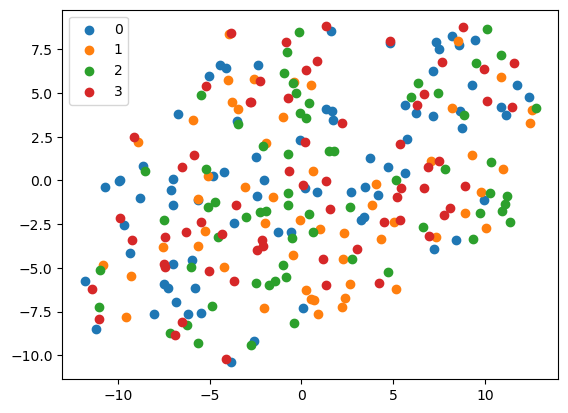

Epoch [60/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.72059
Epoch 00051: adjusting learning rate of group 0 to 1.9618e-01.
Step [0/2]	 Loss: 3.64623
Epoch [60/600]	 Training Loss: 3.7100033569335937	 lr: 0.19618
Epoch [60/600]	 Validation Loss: 3.644164562225342	 lr: 0.19618
Epoch [60/600]	 Time Taken: 0.1679482102394104 minutes
Epoch [61/600]	
Step [0/25]	 Loss: 3.69364
Epoch 00052: adjusting learning rate of group 0 to 1.9603e-01.
Step [0/2]	 Loss: 3.64876
Epoch [61/600]	 Training Loss: 3.706017770767212	 lr: 0.19603
Epoch [61/600]	 Validation Loss: 3.643161177635193	 lr: 0.19603
Epoch [61/600]	 Time Taken: 0.1593762755393982 minutes
Epoch [62/600]	
Step [0/25]	 Loss: 3.70753
Epoch 00053: adjusting learning rate of group 0 to 1.9588e-01.
Step [0/2]	 Loss: 3.64867
Epoch [62/600]	 Training Loss: 3.701619520187378	 lr: 0.19588
Epoch [62/600]	 Validation Loss: 3.644848942756653	 lr: 0.19588
Epoch [62/600]	 Time Taken: 0.1596149444580078 minutes
Epoch [63/600]	
Step [0/25]	 Loss: 3.70659
Epoch 00054: adjusting learning r

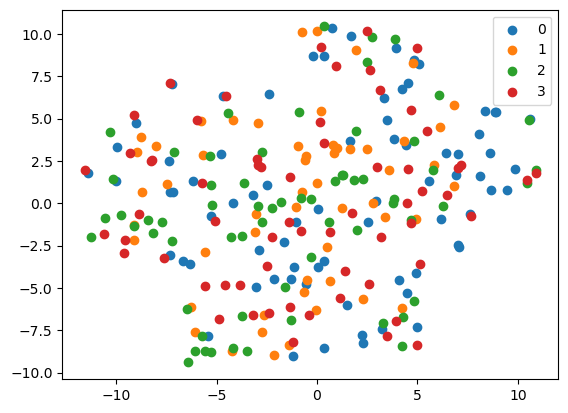

Epoch [70/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.7001
Epoch 00061: adjusting learning rate of group 0 to 1.9456e-01.
Step [0/2]	 Loss: 3.63959
Epoch [70/600]	 Training Loss: 3.6928434562683106	 lr: 0.19456
Epoch [70/600]	 Validation Loss: 3.636431574821472	 lr: 0.19456
Epoch [70/600]	 Time Taken: 0.14417853355407714 minutes
Epoch [71/600]	
Step [0/25]	 Loss: 3.68616
Epoch 00062: adjusting learning rate of group 0 to 1.9438e-01.
Step [0/2]	 Loss: 3.64294
Epoch [71/600]	 Training Loss: 3.6892759227752685	 lr: 0.19438
Epoch [71/600]	 Validation Loss: 3.638345718383789	 lr: 0.19438
Epoch [71/600]	 Time Taken: 0.17615040143330893 minutes
Epoch [72/600]	
Step [0/25]	 Loss: 3.69235
Epoch 00063: adjusting learning rate of group 0 to 1.9420e-01.
Step [0/2]	 Loss: 3.63418
Epoch [72/600]	 Training Loss: 3.6913884830474855	 lr: 0.1942
Epoch [72/600]	 Validation Loss: 3.6317681074142456	 lr: 0.1942
Epoch [72/600]	 Time Taken: 0.15154199997584025 minutes
Epoch [73/600]	
Step [0/25]	 Loss: 3.68451
Epoch 00064: adjusting learnin

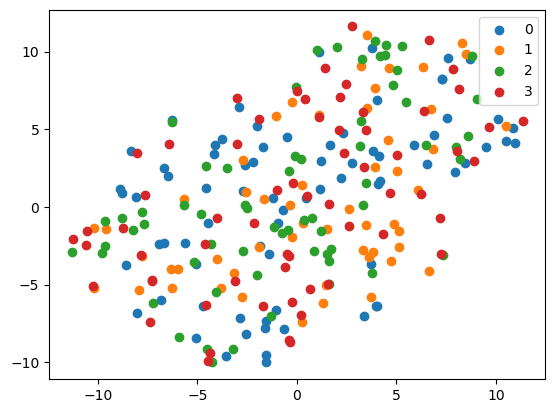

Epoch [80/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.67168
Epoch 00071: adjusting learning rate of group 0 to 1.9266e-01.
Step [0/2]	 Loss: 3.63844
Epoch [80/600]	 Training Loss: 3.675996112823486	 lr: 0.19266
Epoch [80/600]	 Validation Loss: 3.632329225540161	 lr: 0.19266
Epoch [80/600]	 Time Taken: 0.1580256462097168 minutes
Epoch [81/600]	
Step [0/25]	 Loss: 3.6825
Epoch 00072: adjusting learning rate of group 0 to 1.9246e-01.
Step [0/2]	 Loss: 3.63893
Epoch [81/600]	 Training Loss: 3.6782626056671144	 lr: 0.19246
Epoch [81/600]	 Validation Loss: 3.630716562271118	 lr: 0.19246
Epoch [81/600]	 Time Taken: 0.16777899265289306 minutes
Epoch [82/600]	
Step [0/25]	 Loss: 3.67706
Epoch 00073: adjusting learning rate of group 0 to 1.9225e-01.
Step [0/2]	 Loss: 3.63651
Epoch [82/600]	 Training Loss: 3.676138744354248	 lr: 0.19225
Epoch [82/600]	 Validation Loss: 3.6331478357315063	 lr: 0.19225
Epoch [82/600]	 Time Taken: 0.14681700468063355 minutes
Epoch [83/600]	
Step [0/25]	 Loss: 3.68548
Epoch 00074: adjusting learning

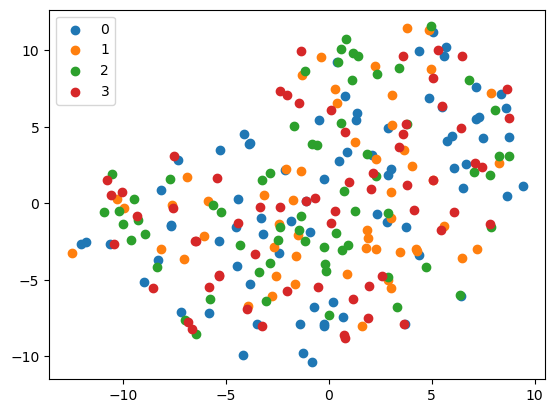

Epoch [90/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.66915
Epoch 00081: adjusting learning rate of group 0 to 1.9049e-01.
Step [0/2]	 Loss: 3.63663
Epoch [90/600]	 Training Loss: 3.6676838302612307	 lr: 0.19049
Epoch [90/600]	 Validation Loss: 3.6308330297470093	 lr: 0.19049
Epoch [90/600]	 Time Taken: 0.17268288532892864 minutes
Epoch [91/600]	
Step [0/25]	 Loss: 3.66735
Epoch 00082: adjusting learning rate of group 0 to 1.9026e-01.
Step [0/2]	 Loss: 3.63602
Epoch [91/600]	 Training Loss: 3.6654741096496584	 lr: 0.19026
Epoch [91/600]	 Validation Loss: 3.6301265954971313	 lr: 0.19026
Epoch [91/600]	 Time Taken: 0.14828492800394694 minutes
Epoch [92/600]	
Step [0/25]	 Loss: 3.65811
Epoch 00083: adjusting learning rate of group 0 to 1.9003e-01.
Step [0/2]	 Loss: 3.63297
Epoch [92/600]	 Training Loss: 3.6620351123809813	 lr: 0.19003
Epoch [92/600]	 Validation Loss: 3.631040930747986	 lr: 0.19003
Epoch [92/600]	 Time Taken: 0.18061782916386923 minutes
Epoch [93/600]	
Step [0/25]	 Loss: 3.65941
Epoch 00084: adjusting lea

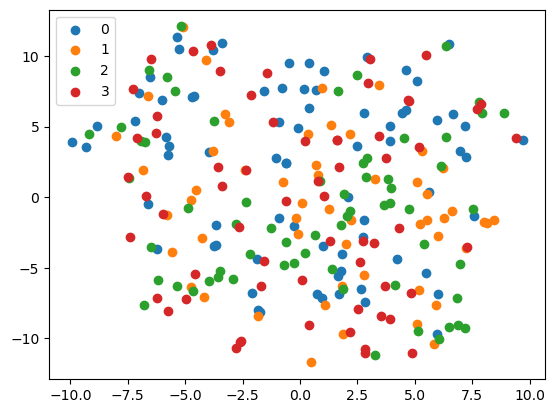

Epoch [100/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.64643
Epoch 00091: adjusting learning rate of group 0 to 1.8807e-01.
Step [0/2]	 Loss: 3.63196
Epoch [100/600]	 Training Loss: 3.658835868835449	 lr: 0.18807
Epoch [100/600]	 Validation Loss: 3.6275850534439087	 lr: 0.18807
Epoch [100/600]	 Time Taken: 0.16063249508539837 minutes
Epoch [101/600]	
Step [0/25]	 Loss: 3.64188
Epoch 00092: adjusting learning rate of group 0 to 1.8781e-01.
Step [0/2]	 Loss: 3.63144
Epoch [101/600]	 Training Loss: 3.657675447463989	 lr: 0.18781
Epoch [101/600]	 Validation Loss: 3.627326488494873	 lr: 0.18781
Epoch [101/600]	 Time Taken: 0.15826364358266196 minutes
Epoch [102/600]	
Step [0/25]	 Loss: 3.64891
Epoch 00093: adjusting learning rate of group 0 to 1.8756e-01.
Step [0/2]	 Loss: 3.62898
Epoch [102/600]	 Training Loss: 3.6551580810546875	 lr: 0.18756
Epoch [102/600]	 Validation Loss: 3.6268203258514404	 lr: 0.18756
Epoch [102/600]	 Time Taken: 0.15032681624094646 minutes
Epoch [103/600]	
Step [0/25]	 Loss: 3.66146
Epoch 00094: adj

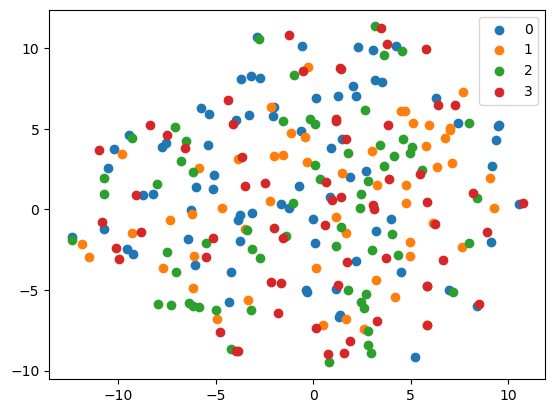

Epoch [110/600]	


/home/aarya/miniconda3/envs/pyTorch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step [0/25]	 Loss: 3.64726
Epoch 00101: adjusting learning rate of group 0 to 1.8540e-01.
Step [0/2]	 Loss: 3.63329
Epoch [110/600]	 Training Loss: 3.6489131927490233	 lr: 0.1854
Epoch [110/600]	 Validation Loss: 3.6298211812973022	 lr: 0.1854
Epoch [110/600]	 Time Taken: 0.15404507716496785 minutes
Epoch [111/600]	
Step [0/25]	 Loss: 3.65037
Epoch 00102: adjusting learning rate of group 0 to 1.8512e-01.
Step [0/2]	 Loss: 3.62851
Epoch [111/600]	 Training Loss: 3.6503444004058836	 lr: 0.18512
Epoch [111/600]	 Validation Loss: 3.624908685684204	 lr: 0.18512
Epoch [111/600]	 Time Taken: 0.2004260778427124 minutes
Epoch [112/600]	
Step [0/25]	 Loss: 3.64462
Epoch 00103: adjusting learning rate of group 0 to 1.8483e-01.
Step [0/2]	 Loss: 3.63156
Epoch [112/600]	 Training Loss: 3.6471341133117674	 lr: 0.18483
Epoch [112/600]	 Validation Loss: 3.6251147985458374	 lr: 0.18483
Epoch [112/600]	 Time Taken: 0.17168187300364177 minutes
Epoch [113/600]	
Step [0/25]	 Loss: 3.64045


KeyboardInterrupt: 

In [35]:
nr = 0
current_epoch = 0
epochs = 600
tr_loss = []
val_loss = []

for epoch in range(epochs):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dl):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(dl)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()
    
    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(vdl):
        
          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i = model(x_i)
          z_j = model(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 50 == 0:
              print(f"Step [{step}/{len(vdl)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    if nr == 0:
        tr_loss.append(tr_loss_epoch / len(dl))
        val_loss.append(val_loss_epoch / len(vdl))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.pretrained, 4, 2048, 128)

save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")